[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahdimplus/DeepRetroMoco/blob/main/network/train_with_validtiondatafunctions.ipynb)

In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [5]:
d1='/content/drive/MyDrive/data/data selection_D1/S02_MSL.nii.gz'
import nibabel as nib

def load_m (file_path):
    
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    if img.shape[0:2]!=(64,64):
    
        img_data = img_data[23:87,23:87,:,:]
        
    if not (file_path.endswith(".nii") or file_path.endswith(".nii.gz")):
        raise ValueError(
              f"Nifti file path must end with .nii or .nii.gz, got {file_path}."
                        )
    return img_data
z=load_m(d1)



In [86]:
z1=z[...,4,0]
z2=z[...,4,80]

In [19]:
import numpy as np

In [50]:
import keras.backend as K


In [51]:
def TSNR(z1,z2):
    mean=(z1+z2)/2
    std1=(z1-mean)**2
    std2=(z2-mean)**2
    return K.mean(K.sqrt(sum(std1,std2)/2))


In [35]:
pip install voxelmorph


     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 


In [36]:
# imports
# local imports
import voxelmorph as vxm
import neurite as ne
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
import nibabel as nib

#import nbimporter
#from functions import *


In [37]:
#m=maxx(data_dir)
m=1584 

In [38]:
import random
def load_m (file_path):
    
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    if img.shape[0:2]!=(64,64):
    
        img_data = img_data[23:87,23:87,:,:]
        
    if not (file_path.endswith(".nii") or file_path.endswith(".nii.gz")):
        raise ValueError(
              f"Nifti file path must end with .nii or .nii.gz, got {file_path}."
                        )
    return img_data 
def count (data_dir):
    train_dir = os.path.join(data_dir)

    train_data_num = []
    for file in os.listdir(train_dir):
            train_data_num.append([file])
    train_data_num=np.array(train_data_num) 
    n=train_data_num.shape[0] 

    return n,train_data_num

In [39]:
def data_generator(data_dir, batch_size,m,split):
    """4
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    
    m= maximum between all subject 
    split= percent of validation data
    
    
    """
    
    n,train_data_num=count(data_dir)
    n_train=n-int(split*n)
 
    
    subject_ID=random.randint(0,n_train-1)
    d=load_m(data_dir+'/'+str(train_data_num[subject_ID][0]))

    
    s=d.shape[2]
    slice_ID =random.randint(0,s-1)
    v=d.shape[3]
    
 # preliminary sizing
    vol_shape = d.shape[:2] # extract data shape
    ndims = len(vol_shape)
    
    
    d=d[:,:,slice_ID,:]
    d = np.einsum('jki->ijk', d)

    
    
   
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, v, size=batch_size)
        moving_images = d[idx1, ..., np.newaxis]
        moving_images=moving_images/m
        
        idx2 = np.random.randint(0, v, size=batch_size)
        fixed_images = d[idx2, ..., np.newaxis]
        fixed_images=fixed_images/m
        
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)



def val_generator(data_dir, batch_size,m,split):
  
    n,train_data_num=count(data_dir)
    n_train=n-int(split*n)
    a=n_train
    
    
    subject_ID=random.randint(a,n-1)
    d=load_m(data_dir+'/'+str(train_data_num[subject_ID][0]))

    
    s=d.shape[2]
    slice_ID =random.randint(0,s-1)
    v=d.shape[3]
    
    # preliminary sizing
    vol_shape = d.shape[:2] # extract data shape
    ndims = len(vol_shape)
    
    
    d=d[:,:,slice_ID,:]
    d = np.einsum('jki->ijk', d)

 
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    # prepare inputs:
    # images need to be of the size [batch_size, H, W, 1]
    idx1 = np.random.randint(0, v, size=batch_size)
    moving_images = d[idx1, ..., np.newaxis]
    moving_images=moving_images/m

    idx2 = np.random.randint(0, v, size=batch_size)
    fixed_images = d[idx2, ..., np.newaxis]
    fixed_images=fixed_images/m

    inputs = [moving_images, fixed_images]

    # prepare outputs (the 'true' moved image):
    # of course, we don't have this, but we know we want to compare 
    # the resulting moved image with the fixed image. 
    # we also wish to penalize the deformation field. 
    outputs = [fixed_images,zero_phi]

    return (inputs, outputs)







In [40]:
data_dir='/content/drive/MyDrive/data/data selection_D1'

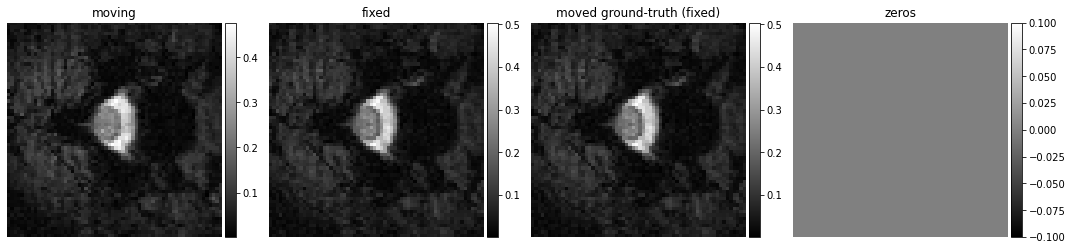

In [41]:
split=0.3  # it means 70% for train and 30% for validation


train_generator = data_generator(data_dir,100,m,split)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);


In [42]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
# data shape 64*64
s=in_sample[0].shape[1:3]
inshape = (*s, unet_input_features)

# configure unet features 
nb_features = [
    [64, 64, 64, 64],         # encoder features
    [64, 64, 64, 64, 64, 32,16]  # decoder features
]

#nb_features = [
#    [32, 32, 32, 32],         # encoder features
#    [32, 32, 32, 32, 32,16]  # decoder features
#           ]

In [ ]:
s

(64, 64)

In [43]:
# build model using VxmDense
inshape =s
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
vxm_model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 target_input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 unet_input_concat (Concatenate  (None, 64, 64, 2)   0           ['source_input[0][0]',           
 )                                                                'target_input[0][0]']           
                                                                                                  
 unet_enc_conv_0_0 (Conv2D)     (None, 64, 64, 64)   1216        ['unet_input_concat[0][0]

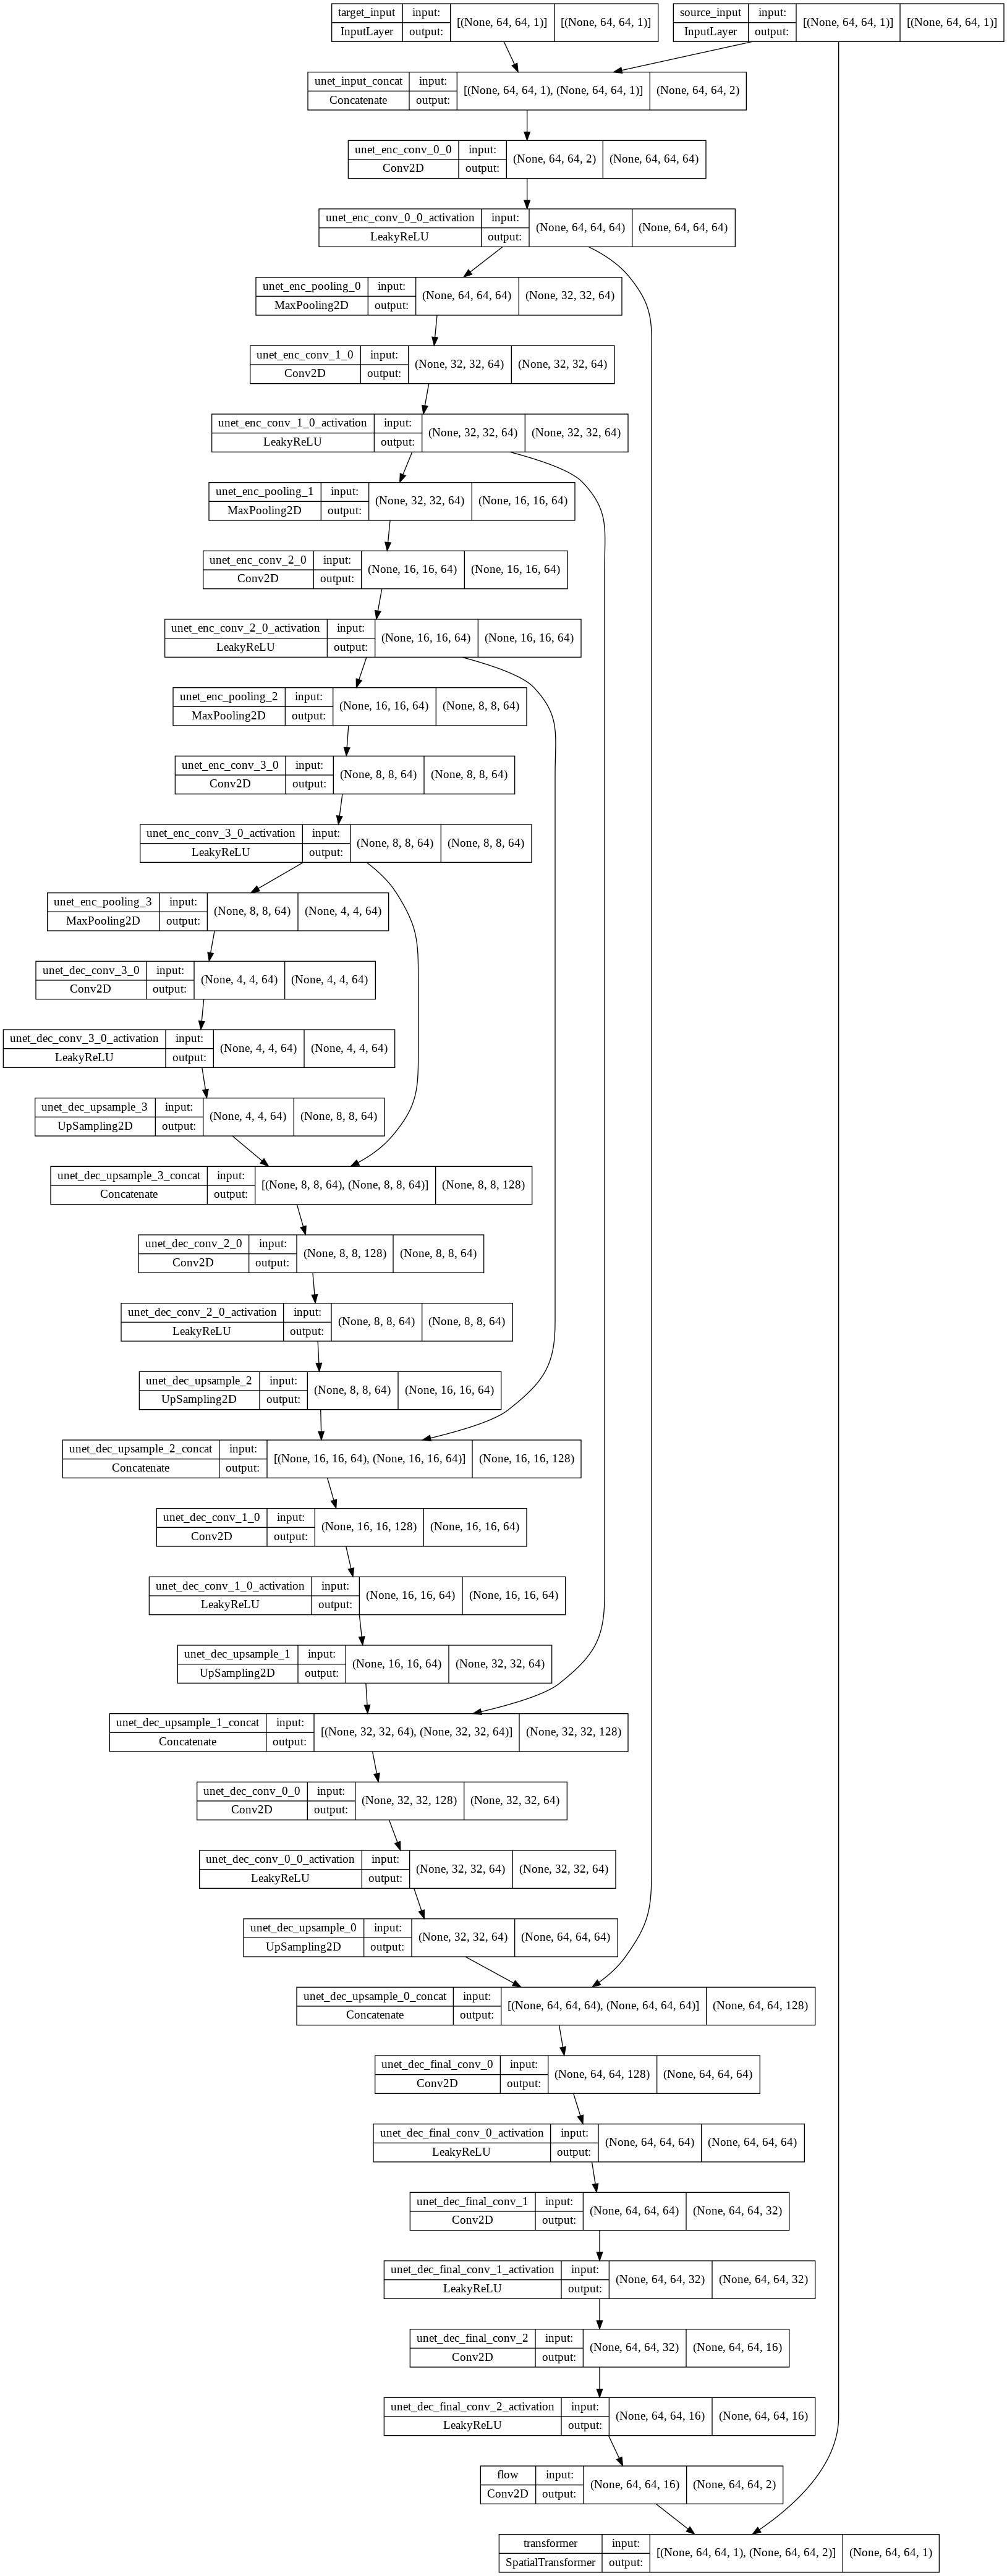

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(vxm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [44]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0
loss_weights = [1, lambda_param]

In [133]:
import numpy as np
import tensorflow as tf
from keras import backend as K
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [192]:
def TSNR(source_input,transformer):
    M=(source_input+transformer)/2
    std1=(source_input-M)**2
    std2=(transformer-M)**2
    std=K.sqrt((std1+std2)/2)
    #std[K.where(std==0)]=10e-5
    #td[np.argwhere(std == 0)]=10e-5
    #std[std==0]=10e-5 
    final=int(K.mean(M/std))
    return final

In [173]:
TSNR()

TypeError: ignored

In [185]:
M=(z1+z2)/2
std1=(z1-M)**2
std2=(z2-M)**2
std=np.sqrt((std1+std2)/2)
#std[np.argwhere(std == 0)]=10e-5

np.mean(M/std)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


inf

In [187]:
std[std==0]=5

In [183]:
np.where(std==0)

(array([], dtype=int64), array([], dtype=int64))

In [202]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights, metrics=[TSNR])

In [203]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
#es = EarlyStopping(monitor='transformer_TSNR', mode='max', min_delta=1, patience=5, verbose=1)
#annealer = ReduceLROnPlateau(monitor=['val_accuracy','val_mse'] ,factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
nb_epochs =200
steps_per_epoch =100
import time
start=time.time()
hist = vxm_model.fit(train_generator,
                               epochs=nb_epochs,
                               steps_per_epoch=steps_per_epoch,
                               verbose=2,
                               callbacks=[checkpoint],
                               validation_data=val_generator(data_dir,1,1584,.3)
                    );
stop=time.time()
print(f"Training Time:{stop-start}s")

Epoch 1/200

Epoch 1: val_loss improved from inf to -0.61183, saving model to model.h5
100/100 - 30s - loss: -7.7736e-01 - transformer_loss: -7.7736e-01 - flow_loss: 0.8001 - transformer_TSNR: 1911260416.0000 - flow_TSNR: 0.0000e+00 - val_loss: -6.1183e-01 - val_transformer_loss: -6.1183e-01 - val_flow_loss: 0.5122 - val_transformer_TSNR: 58.0000 - val_flow_TSNR: 0.0000e+00 - 30s/epoch - 301ms/step
Epoch 2/200

Epoch 2: val_loss improved from -0.61183 to -0.61444, saving model to model.h5
100/100 - 27s - loss: -8.1300e-01 - transformer_loss: -8.1300e-01 - flow_loss: 0.8432 - transformer_TSNR: 1653562368.0000 - flow_TSNR: 0.0000e+00 - val_loss: -6.1444e-01 - val_transformer_loss: -6.1444e-01 - val_flow_loss: 0.5216 - val_transformer_TSNR: 120.0000 - val_flow_TSNR: 0.0000e+00 - 27s/epoch - 265ms/step
Epoch 3/200

Epoch 3: val_loss improved from -0.61444 to -0.62348, saving model to model.h5
100/100 - 27s - loss: -8.1969e-01 - transformer_loss: -8.1969e-01 - flow_loss: 0.8610 - transforme

In [198]:
vxm_model.save("/content/drive/MyDrive/final/new/NCC_la0_METRIC_model.h5")

In [199]:
vxm_model.save_weights("/content/drive/MyDrive/data/final/NCC_la0_METRIC_weight1.h5")

In [200]:
import pickle

In [201]:
with open('/content/drive/MyDrive/data/final/M01_METRIC', 'wb') as file_pi:
     pickle.dump(hist.history, file_pi)

In [ ]:
history = pickle.load(open('/trainHistoryDict', "rb"))

In [ ]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:
print(history.history.keys())

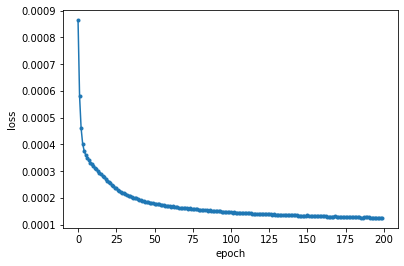

In [ ]:
plot_history(hist)

In [ ]:
data_dir_TEST='/home/mahdi/Desktop/data_selection_D7'

In [ ]:
# let's get some data
val_generator = data_generator(data_dir_TEST,32,m,.3)
val_input, _ = next(val_generator)

In [ ]:
val_pred = vxm_model.predict(val_input)

In [ ]:
# visualize
images = [img[18, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
ne.plot.flow([val_pred[1][18].squeeze()], width=10)